In [2]:
%matplotlib inline
import xgboost as xgb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.datasets

In [3]:
# # SIMPLE DATA
# # DMatrix is a special matrix format for xgboost that can be produced out of numpy arrays
# # One DMatrix consists of two parts, X array and y array xgb.DMatrix(X, label=y)
# dtrain = xgb.DMatrix(np.array([[1,2,3], [3,4,5]]), label=np.array([[0], [1]]))  
# dvalid = xgb.DMatrix(np.array([[1,2,3], [4,4,5]]), label=np.array([[1], [0]]))
# dtest  = xgb.DMatrix(np.array([[1,1,1], [7,8,5]]), label=np.array([[0], [0]]))
# feature_names = ['random1', 'random2', 'random3']

# # Evals is a list of tuple pairs. One tuple contains (DMatrix, 'str name of the set e.g. valid')
# # The last set in this list is going to be the base for early stopping.
# evals = [(dtrain, 'train'), (dtest, 'test'), (dvalid, 'valid')]



# BOSTON HOUSING DATA
# Description of the data here: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston
boston = sklearn.datasets.load_boston(return_X_y=False)

# Shuffling the data
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(boston['data'], boston['target'])
feature_names = boston['feature_names']

# Splitting into train, valid and test sets
trainX = X[0:300, :]
validX = X[300:400, :]
testX = X[400:506, :]

trainY = Y[0:300]
validY = Y[300:400]
testY = Y[400:506]

# Making XGBoost DMatrices
dtrain = xgb.DMatrix(trainX, label=trainY)  
dvalid = xgb.DMatrix(validX, label=validY)
dtest  = xgb.DMatrix(testX , label=testY)
evals = [(dtrain, 'train'), (dtest, 'test'), (dvalid, 'valid')]

In [4]:
# TRAINING

params = {
    # Config of parameters
    # Details & more params here: http://xgboost.readthedocs.io/en/latest/parameter.html
    
    # General parameters
    "booster": 'gbtree',  # Which booster to use - 'gbtree', 'gblinear' or 'dart' (gbtree mostly works best)
    "silent": 0,  # 0 means printing running messages, 1 means silent mode
    "nthread": 8,  # number of parallel threads used to run xgboost, do not set for automatic
    
    # Learning Task Parameters
    "objective": 'reg:linear',
    'base_score': 0.5,
    'eval_metric': 'mae',
    'seed': 0,
    
    # Parameters for tree Booster
    "eta": 0.50, # This is learning rate (default 0.3)
    "gamma": 30.0, # Minimum loss reduction required to make a further partition on a leaf node of the tree. Larger gamma results in more conservative altorithm. (default 0)
    "max_depth": 6, # maximum depth of a tree, increase this value will make the model more complex / likely to be overfitting. 0 indicates no limit, limit is required for depth-wise grow policy. (default 6)
}

tvh = {}  # Eval results will be saved in this dictionary
booster = xgb.train(params,  # Dict of booster parameters
          dtrain,  # Training data
          num_boost_round=1000,  # Number of iterations
          evals=evals,  # One or more sets of evaluation data (might be e.g. train and valid sets)
          early_stopping_rounds=10,  # Default: None, Sets early stopping, Requires validation data
          evals_result=tvh,  # Dictionary that stores evaluation results
          verbose_eval=5,  # True or int, Prints evaluation results on each iteration or on multiple of int
          xgb_model=None,  # XGB model to be loaded before training. File name of stored xgb model or Booster instance
          callbacks=None,  # List of callback function that are applied at each iteration
          obj=None,  # Customized objective (cost or loss) function
          feval=None,  # Customized evaluation function
          maximize=False,  # Whether to maximize feval
          learning_rates=None  # List for each iteration or function f: eta = f(boosting round, num_boost_round)
          )

[0]	train-mae:11.105	test-mae:12.242	valid-mae:11.2682
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 10 rounds.
[5]	train-mae:1.48474	test-mae:2.8214	valid-mae:2.78034
[10]	train-mae:1.42441	test-mae:2.7256	valid-mae:2.72218
[15]	train-mae:1.38874	test-mae:2.73554	valid-mae:2.71189
[20]	train-mae:1.38881	test-mae:2.73546	valid-mae:2.71183
[25]	train-mae:1.38881	test-mae:2.73546	valid-mae:2.71183
[30]	train-mae:1.38881	test-mae:2.73546	valid-mae:2.71183
Stopping. Best iteration:
[24]	train-mae:1.38881	test-mae:2.73546	valid-mae:2.71183



In [5]:
# Get best results
best_iter = booster.best_iteration
best_score = booster.best_score

print('Best epoch: {0}'.format(best_iter))
print('{set} score: {score}'.format(set=evals[-1][1], score=best_score))

Best epoch: 24
valid score: 2.711825


In [6]:
# Saving trained booster to a file
model_path = 'output/E{0}-V{1:.2f}.xgbmodel'.format(best_iter, best_score)
booster.save_model(model_path)

# Loading trained booster from a file
booster = xgb.Booster({"nthread": -1,})
booster.load_model(model_path)

In [7]:
# Get predictions on test set
predictions = booster.predict(dtest)  # List of predictions
dfp = pd.DataFrame({'predicted': predictions})

# Print first 5 predictions
print(dfp.head())

# Save predictions as csv
dfp.to_csv('output/predictions.csv')

   predicted
0  44.887016
1  23.691811
2  27.121712
3  20.727520
4  19.665796


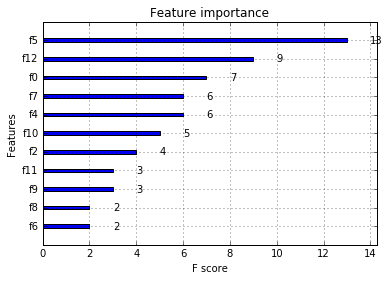

In [8]:
# Visualize feature importance (type is either weight, gain or cover)
# Deatails here: https://github.com/dmlc/xgboost/blob/2e9d06443e4793231dd9ac841f7a7879f11b1d47/python-package/xgboost/plotting.py
xgb.plot_importance(booster, importance_type='weight')
plt.savefig('output/fimport.pdf')

In [9]:
# Print list of features for convenience
print('Features: {}'.format(['{}: {}'.format(i, x) for i, x in enumerate(feature_names)]))

Features: ['0: CRIM', '1: ZN', '2: INDUS', '3: CHAS', '4: NOX', '5: RM', '6: AGE', '7: DIS', '8: RAD', '9: TAX', '10: PTRATIO', '11: B', '12: LSTAT']


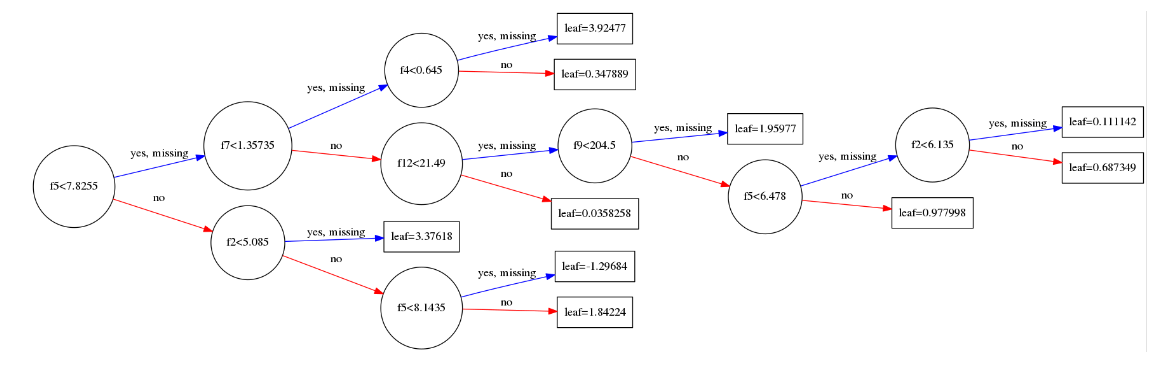

In [10]:
# Visualize tree, do not use if tree is going to be too large. The image tends to be very large
xgb.plot_tree(booster, num_trees=4, rankdir='LR')
fig = plt.gcf()

# Set size of tree visualizaton in inches to approx. reflect the real size of the tree for better quality image
fig.set_size_inches(20, 60)
fig.savefig('output/tree.pdf')
# fig.savefig('output/tree.png')

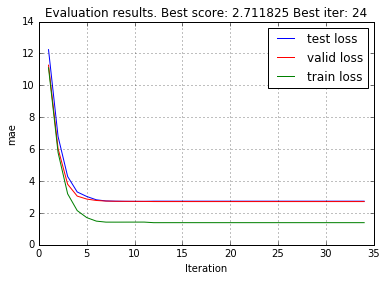

In [11]:
# Visualize the training
def plot_tvh(tvh, best_iter, best_score=None, metric='loss', lossfunc=None, fname=None):
    val_metric = 'val_{}'.format(metric)

    fig, ax = plt.subplots(1, 1)
    # tick_spacing = 1
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    plt.title('Evaluation results. Best score: {} Best iter: {}'.format(best_score, best_iter))
    plt.xlabel('Iteration')
    plt.ylabel(lossfunc)
    plt.grid(True)
    
    # Plot metric over number of epochs
    xaxes = list(range(1, len(tvh[list(tvh.keys())[0]][lossfunc]) + 1))
    
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']
    for i, key in enumerate(list(tvh.keys())):
        plt.plot(xaxes, tvh[key][lossfunc], '{}-'.format(colors[i]), label='{set} {metric}'.format(set=key, metric=metric), linewidth=1.0)
    
    plt.legend(loc='upper right')
    plt.savefig(fname)
    plt.show()
    plt.close()
    
lossfunc = params['eval_metric']
plot_tvh(tvh, best_iter, best_score=best_score, lossfunc=lossfunc, fname='output/tvh.pdf')